In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

from DataProc.DataProcessor import DataProcessor
from Datasets.BaseballDataset import BaseballDataset
from BaselineModel.BaselineModel import BaselineModel
from TransformerModel.TransformerModelRedisual import *

import torch
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
data_config_path = "../../data/configv3.json"
full_data_path = "../../data/full_cleaned_94.csv"
full_data = pd.read_csv(full_data_path)

In [3]:
sequence_length = 400

In [4]:
#for each zone for pitch location and each hit_location, we need to calculate average coords to fill our examples with
# hc_x, hc_y #hit coords
# plate_x, plate_z #pitch coords

hit_coords_means = dict()
hit_loc_cols = [col for col in full_data.columns if col.startswith('hit_location')]

pitch_coords_means = dict()
zone_cols = [col for col in full_data.columns if col.startswith('zone')]



for col in hit_loc_cols:
    hc_x_mean = full_data[full_data[col] == True]['hc_x'].mean()
    hc_y_mean = full_data[full_data[col] == True]['hc_y'].mean()

    hit_coords_means[col] = (hc_x_mean,hc_y_mean)

for col in zone_cols:
    plate_x_mean = full_data[full_data[col] == True]['plate_x'].mean()
    plate_z_mean = full_data[full_data[col] == True]['plate_z'].mean()

    pitch_coords_means[col] = (plate_x_mean,plate_z_mean)

In [5]:
scaler_path = "../../data/full_scalers_94.pkl"
with open(scaler_path, "rb") as file:
    scalers = pickle.load(file)

In [26]:
start_date = "2022-06-01" #date from which new examples will be added
player = "josh naylor"

#get previous (sequence_length) pitches for this player starting at start_date
filtered_data = full_data[(full_data['batter_name'] == player) & (full_data['game_date'] <= start_date)].sort_values(by=['game_date']).tail(sequence_length)









In [7]:
pitcher = "dylan cease"
pitcher_context_size = 2000 #abitrary for now
pitcher_data = full_data[(full_data['pitcher_name'] == pitcher) & (full_data['game_date'] <= start_date)].sort_values(by=['game_date']).tail(pitcher_context_size)



In [8]:
pitcher_data

,pitch_number,launch_speed,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,pfx_x,pfx_z,...,balls_0,balls_1,balls_2,balls_3,strikes_0,strikes_1,strikes_2,outs_when_up_0,outs_when_up_1,outs_when_up_2
2168707,6,-0.440642,2021-07-27,-0.614621,-0.643936,0.654449,656811,656302,0.844463,-0.970856,...,False,False,False,True,False,False,True,True,False,False
2168738,3,-0.602708,2021-07-27,1.295022,-0.232475,1.038678,521692,656302,-0.139710,1.092012,...,False,False,True,False,True,False,False,False,False,True
2168705,8,1.454287,2021-07-27,-0.332326,-0.749438,0.558392,656811,656302,0.471156,-0.836904,...,False,False,False,True,False,False,True,True,False,False
2168706,7,-0.527908,2021-07-27,1.328233,-0.622835,0.865775,656811,656302,-0.298082,1.025036,...,False,False,False,True,False,False,True,True,False,False
2168671,6,-0.002704,2021-07-27,-0.249298,-0.596459,0.443123,467793,656302,0.867087,-1.211971,...,False,True,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658809,3,-0.002704,2022-05-29,-0.182875,-0.396004,0.846563,664731,656302,0.618216,-0.850299,...,False,False,True,False,True,False,False,False,False,True
1658810,2,-0.002704,2022-05-29,1.494289,-0.332702,1.077101,664731,656302,0.278846,0.998246,...,False,True,False,False,True,False,False,False,False,True
1658811,1,-0.002704,2022-05-29,-0.249298,-0.411829,0.808141,664731,656302,0.584279,-1.185180,...,True,False,False,False,True,False,False,False,False,True
1658790,4,1.329621,2022-05-29,1.510895,-0.396004,1.038678,664023,656302,-0.162334,0.703550,...,False,True,False,False,False,False,True,False,False,True


In [9]:
pitch_stat_cols = ['release_speed', 'release_pos_x','release_pos_z','pfx_x', 'pfx_z', 'plate_x','plate_z', 'hc_x', 'hc_y', 'vy0',
                    'vz0', 'ax', 'ay', 'az', 'sz_top','sz_bot', 'release_spin_rate', 'release_extension', 'release_pos_y']

pitch_type_cols = ['pitch_type_CH', 'pitch_type_CS',
       'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FA', 'pitch_type_FC',
       'pitch_type_FF', 'pitch_type_FO', 'pitch_type_FS', 'pitch_type_KC',
       'pitch_type_KN', 'pitch_type_PO', 'pitch_type_SC', 'pitch_type_SI',
       'pitch_type_SL', 'pitch_type_ST', 'pitch_type_SV']

batter_stat_cols = []








In [10]:
pitcher_pitch_stats = dict()

for pitch_type in pitch_type_cols:

    if pitcher_data[pitch_type].sum() > 0:

        #get data for all pitches with this pitch type, and get the mean for each necessary stat column
        means_dict = pitcher_data[pitcher_data[pitch_type] == True][pitch_stat_cols].mean().to_dict()

        #save means dict for this pitch_type to dict for this pitcher
        pitcher_pitch_stats[pitch_type] = means_dict


In [11]:
pitcher_pitch_stats.keys()

dict_keys(['pitch_type_CH', 'pitch_type_FF', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'pitch_type_ST'])

In [12]:
#pitch info should be dict/json with user input info about the pitch, basically all info not included in pitch_stats, these are not standardized as well

pL = pitcher_data.iloc[0]['p_throws_L']
pR = pitcher_data.iloc[0]['p_throws_R']

pitch_info = {

    'launch_speed': 82,
    'launch_angle': 30,
    'game_pk' : 0, #filler metadata, not important
    'batter_name': player,
    'pitcher_name': pitcher,
    'event': 'events_S', #should contain the name of the column which should be true
    'zone': 5, #should contain the zone number for the pitch location 
    'pitch_type': 'pitch_type_FF', #should contain column name for pitch_type, this should only be a pitch that this pither throws
    'p_throws_L': pL,
    'p_throws_R': pR,
    'hit_location': 0, #hit_location that should be true
    'balls': 0, #number of balls pre-pitch
    'strikes': 0, #number of strikes pre-pitch
    'outs': 0 #number of outs pre-pitch


}

In [13]:

def make_pitch(pitch_stats, pitch_info, pitch_coord_means, hit_coord_means, scalers):

    #check pitcher throws this type of pitch

    if pitch_info['pitch_type'] not in pitch_stats:
        raise Exception(f"Pitcher does not throw pitch type: {pitch_info['pitch_type']}")
    

    #create copy of single batter pitch
    new_pitch = filtered_data.iloc[[0]].copy()


    #populate with mean pitch stats for this specific pitch/pitcher
    for key, val in pitch_stats[pitch_info['pitch_type']].items():
        new_pitch[key] = val
    

    #populate new pitch with use scaled input info
    for key, val in pitch_info.items():

        #check of the key is a pitch column - we have to handle the one-hot encoded ones seperately
        if key not in new_pitch.columns:
            continue

        if key == 'launch_speed' or key == 'launch_angle': #it needs scaling
            scaler = scalers[key]
            
            val = (val - scaler.mean_) / scaler.scale_
        
        new_pitch[key] = val
    

    #for hc_x, hc_y, plate_x, plate_z use the mean coordinates for the selected zone/hit location
    hc_x, hc_y = hit_coord_means[f"hit_location_{pitch_info['hit_location']}.0"]
    plate_x, plate_z = pitch_coord_means[f"zone_{pitch_info['zone']}.0"]

    new_pitch['hc_x'] = hc_x
    new_pitch['hc_y'] = hc_y
    new_pitch['plate_x'] = plate_x
    new_pitch['plate_z'] = plate_z

    
    #handle categorical ones seperately, this is terribly ugly but its fine
    for col in new_pitch.columns:
        if col.startswith('events_'):

            if col == pitch_info['event']:
                new_pitch[col] = True
            else:
                new_pitch[col] = False
    
        elif col.startswith('zone_'):

            if col == f"zone_{pitch_info['zone']}.0":
                new_pitch[col] = True
            else:
                new_pitch[col] = False

        elif col.startswith('pitch_type_'):

            if col == pitch_info['pitch_type']:
                new_pitch[col] = True
            else:
                new_pitch[col] = False
        
        elif col.startswith('hit_location_'):

            if col == f"hit_location_{pitch_info['hit_location']}.0":
                new_pitch[col] = True
            else:
                new_pitch[col] = False
        
        elif col.startswith('balls_'):

            if col == f"balls_{pitch_info['balls']}":
                new_pitch[col] = True
            else:
                new_pitch[col] = False

        elif col.startswith('strikes_'):

            if col == f"strikes_{pitch_info['strikes']}":
                new_pitch[col] = True
            else:
                new_pitch[col] = False

        elif col.startswith('outs_when_up'):

            if col == f"outs_when_up_{pitch_info['outs']}":
                new_pitch[col] = True
            else:
                new_pitch[col] = False
        
    return new_pitch







    

In [14]:
m_path = "../fixed_large_400/h12_e12_h96_d0_lp0.3_lr1e-05_ep40//transformer_model.pth"
c_path = "../fixed_large_400/h12_e12_h96_d0_lp0.3_lr1e-05_ep40//model_config.json"

transformer_model = TransformerHelper(m_path,c_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
import matplotlib.pyplot as plt

# Function to plot pie chart with labels outside and leader lines
def plot_pie_chart(df_row, scenario):
    plt.figure(figsize=(7, 7))  # Adjust the figure size to accommodate labels
    wedges, texts, autotexts = plt.pie(df_row, autopct='%1.1f%%',
                                       wedgeprops={'edgecolor': 'black'},
                                       startangle=90,  # Start from the top
                                       pctdistance=0.8,  # Adjust percentage text location inside the pie
                                       labeldistance=1.2,  # Move labels further out
                                       labels=df_row.index)  # Labels from the index (event names)

    # Set properties for better readability
    for text in texts:
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_fontsize(8)
        autotext.set_color('black')

    # Add legend outside to avoid overlap with the pie chart
    plt.legend(wedges, df_row.index, title="Events", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.title(f'Probability Distribution for {scenario}')
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()


In [16]:
import seaborn as sns



def plot_hit_location(hit_location_means, df_probs):
    # Invert the coordinates by flipping both x and y axes
    def invert_coordinates(x, y):
        return x, -y

    # Set number of total points you want to sample
    total_points = 1000
    std_dev = 0.2

    # Create a figure for density plot
    plt.figure(figsize=(8, 8))

    # Prepare x, y lists for all sampled points
    x_all, y_all = [], []

    # Sample points based on the probability distribution
    for hit_loc, mean in hit_location_means.items():
        # Get probability from DataFrame
        if hit_loc == "hit_location_0.0":
            continue
        probability = df_probs[hit_loc]
        
        # Determine how many points to sample based on probability
        num_points = int(probability * total_points)
        
        # Sample points and invert coordinates
        x_samples, y_samples = invert_coordinates(
            np.random.normal(loc=mean[0], scale=std_dev, size=num_points),
            np.random.normal(loc=mean[1], scale=std_dev, size=num_points)
        )
        
        # Add to total list of points
        x_all.extend(x_samples)
        y_all.extend(y_samples)

    # Plot kernel density estimate based on sampled points
    sns.kdeplot(x=x_all, y=y_all, fill=True)

    # Add markers for bases and pitcher's mound
    base_marker_size = 100
    
    # Home Plate at (0, 0)
    plt.scatter(0, -4.5, color='tan', label="Home Plate", s=base_marker_size, marker='s')
    
    # Pitcher's Mound at (0, -2.5)
    plt.scatter(0, -2.5, color='brown', label="Pitcher's Mound", s=base_marker_size, marker='o')

    # First Base at (2, -2.5)
    plt.scatter(2, -2.5, color='red', label="First Base", s=base_marker_size, marker='s')

    # Second Base at (0, -1)
    plt.scatter(0, -1, color='blue', label="Second Base", s=base_marker_size, marker='s')

    # Third Base at (-2, -2.5)
    plt.scatter(-2, -2.5, color='green', label="Third Base", s=base_marker_size, marker='s')

    # Add foul lines
    # Foul lines extend from home plate outward at 45-degree angles
    plt.plot([0, 6], [-4.5, 1.5], color='black', linestyle='--', label="Foul Line")  # Right field foul line
    plt.plot([0, -6], [-4.5, 1.5], color='black', linestyle='--')  # Left field foul line

    # Add labels and legend
    plt.title('Hit Location Density Plot with Baseball Field Markers and Foul Lines')
    plt.xlabel('X Coordinate (Inverted)')
    plt.ylabel('Y Coordinate (Inverted)')
    plt.legend()

    # Show the plot
    plt.show()



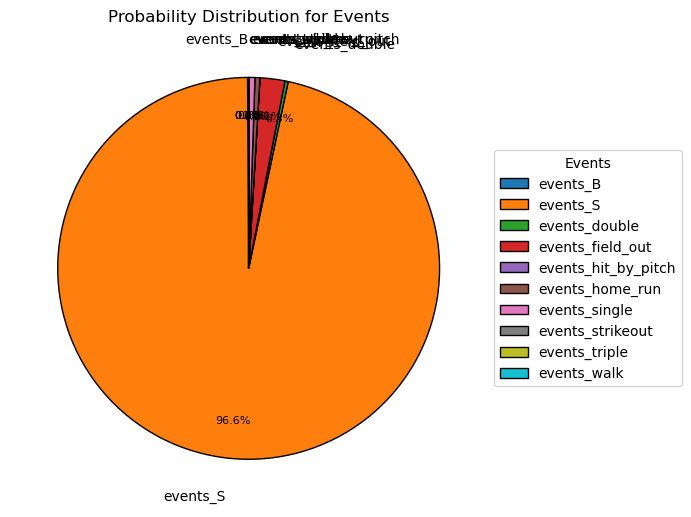

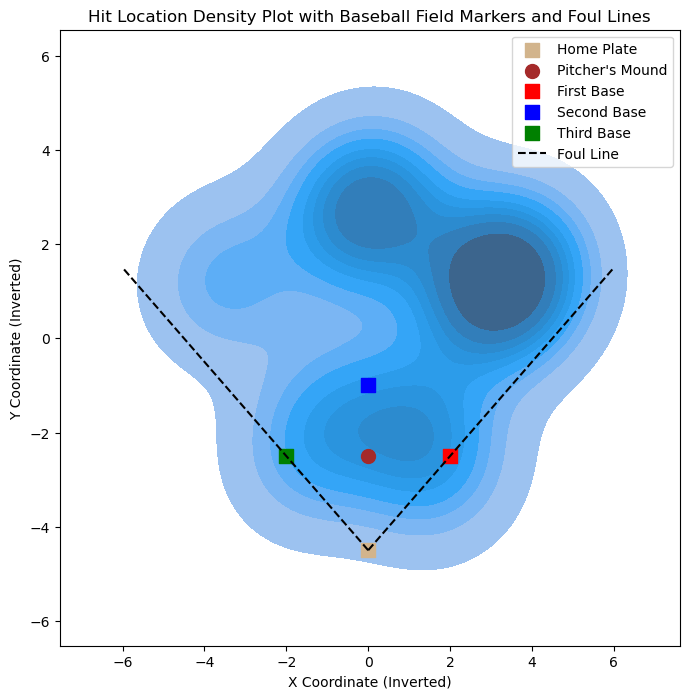

In [27]:
from datetime import datetime, timedelta
#when adding new pitches to the filtered data, we need to make the game_date for new pitches come after the final one
#also need to increment at_bat number


#pitch info should be dict/json with user input info about the pitch, basically all info not included in pitch_stats, these are not standardized as well

pL = pitcher_data.iloc[0]['p_throws_L']
pR = pitcher_data.iloc[0]['p_throws_R']

pitch_info = {

    'launch_speed': 82,
    'launch_angle': 30,
    'game_pk' : 0, #filler metadata, not important
    'batter_name': player,
    'pitcher_name': pitcher,
    'event': 'events_S', #should contain the name of the column which should be true
    'zone': 2, #should contain the zone number for the pitch location 
    'pitch_type': 'pitch_type_CH', #should contain column name for pitch_type, this should only be a pitch that this pither throws
    'p_throws_L': pL,
    'p_throws_R': pR,
    'hit_location': 0, #hit_location that should be true
    'balls': 0, #number of balls pre-pitch
    'strikes': 0, #number of strikes pre-pitch
    'outs': 0 #number of outs pre-pitch


}


new_pitches = [pitch_info] #list of pitches to be added, should be a list of dicts like pitch_info
sequence_data = filtered_data.copy()


curr_date = datetime.strptime(filtered_data['game_date'].max(), '%Y-%m-%d') #latest date
ab_number = 1
pitch_number = 1
for p in new_pitches:
    curr_date = curr_date + timedelta(days=1)
    p['game_date'] = curr_date.strftime('%Y-%m-%d')
    
    p['at_bat_number'] = ab_number
    ab_number += 1

    p['pitch_number'] = pitch_number
    pitch_number += 1

    sequence_data = pd.concat([sequence_data,make_pitch(pitcher_pitch_stats, p, pitch_coords_means, hit_coords_means, scalers)])

sequence_data.reset_index(drop=True, inplace=True)



new_dataset = BaseballDataset(sequence_data, data_config_path, sequence_length)
# Get preds and true using this dataset
player_preds, player_true = transformer_model.make_preds(new_dataset, scaler_path, device, 2000, scale=True)


# Example of selecting one row of probabilities and plotting
plot_pie_chart(player_preds.iloc[-1, 4:14], "Events")
# Example of selecting one row of probabilities and plotting
plot_hit_location(hit_coords_means, player_preds.iloc[-1, 14:])


In [18]:
player_preds.iloc[-1, 14:]

hit_location_0.0    0.973699
hit_location_1.0    0.000748
hit_location_2.0    0.000737
hit_location_3.0    0.002608
hit_location_4.0    0.002860
hit_location_5.0    0.002226
hit_location_6.0    0.001744
hit_location_7.0    0.002709
hit_location_8.0    0.005140
hit_location_9.0    0.007528
Name: 1, dtype: float64

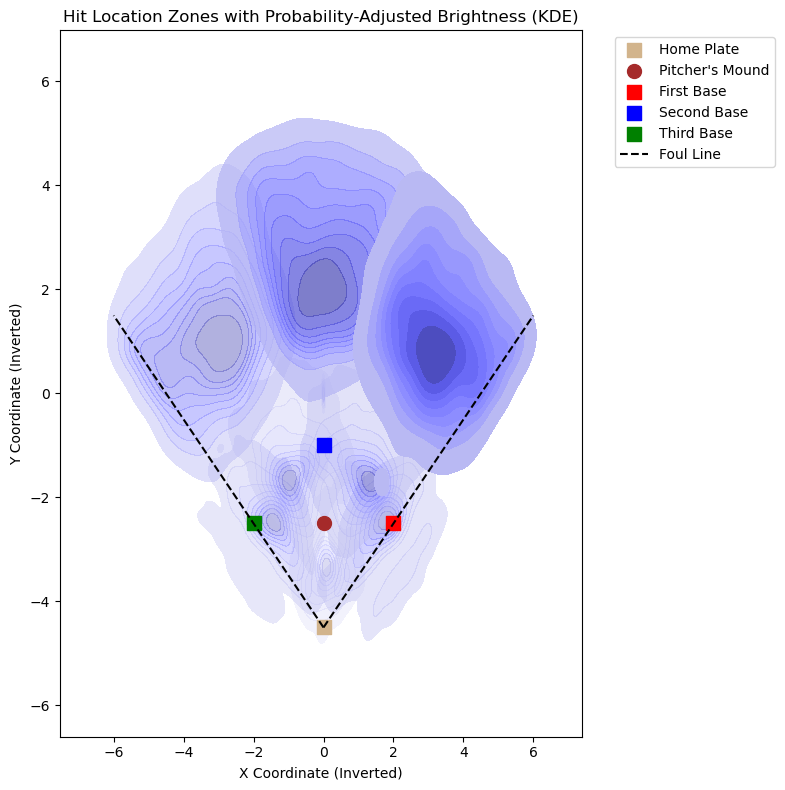

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot hit zones with brightness adjusted by probability
def plot_hit_location_with_brightness(hit_location_means, df_probs, df):
    plt.figure(figsize=(8, 8))

    # Normalize probabilities to a scale between [0.2, 1] for alpha values
    min_alpha, max_alpha = 0.2, 1.0
    probabilities = df_probs.drop('hit_location_0.0').values  # Drop hit_location_0.0 since we don't use it
    prob_min, prob_max = probabilities.min(), probabilities.max()
    
    def normalize_prob(prob):
        """Normalize probability to range [0.2, 1.0] for alpha and ensure it's within [0, 1]."""
        norm_alpha = min_alpha + (max_alpha - min_alpha) * (prob - prob_min) / (prob_max - prob_min)
        return np.clip(norm_alpha, 0, 1)  # Ensure alpha is between 0 and 1

    # Plot KDE for each hit location with alpha based on its probability
    for hit_loc in df.columns:
        if not hit_loc.startswith('hit_location_') or hit_loc == 'hit_location_0.0':
            continue

        # Get the corresponding probability for the hit location
        prob = df_probs[hit_loc]

        # Normalize the probability to determine alpha (transparency)
        alpha = normalize_prob(prob)

        # Filter the DataFrame to get rows where this hit_location is true
        hit_data = df[df[hit_loc] == 1]

        # Extract the coordinates and invert y-coordinates
        x_coords = hit_data['hc_x'].values
        y_coords = -hit_data['hc_y'].values

        # Skip if there are fewer than 3 points
        if len(x_coords) < 3:
            continue

        # Plot KDE with adjusted brightness (alpha) for each zone
        sns.kdeplot(x=x_coords, y=y_coords, color='blue', fill=True, alpha=alpha, label=f'Zone {hit_loc}')

    # Add markers for bases and pitcher's mound
    base_marker_size = 100
    plt.scatter(0, -4.5, color='tan', label="Home Plate", s=base_marker_size, marker='s')
    plt.scatter(0, -2.5, color='brown', label="Pitcher's Mound", s=base_marker_size, marker='o')
    plt.scatter(2, -2.5, color='red', label="First Base", s=base_marker_size, marker='s')
    plt.scatter(0, -1, color='blue', label="Second Base", s=base_marker_size, marker='s')
    plt.scatter(-2, -2.5, color='green', label="Third Base", s=base_marker_size, marker='s')

    # Add foul lines
    plt.plot([0, 6], [-4.5, 1.5], color='black', linestyle='--', label="Foul Line")
    plt.plot([0, -6], [-4.5, 1.5], color='black', linestyle='--')

    plt.title('Hit Location Zones with Probability-Adjusted Brightness (KDE)')
    plt.xlabel('X Coordinate (Inverted)')
    plt.ylabel('Y Coordinate (Inverted)')
    
    # Move the legend outside of the plot area to the right
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function with hit location means, probabilities, and full dataset
plot_hit_location_with_brightness(hit_coords_means, player_preds.iloc[-1, 14:], full_data[full_data['game_date'] > '2024-04-01'])


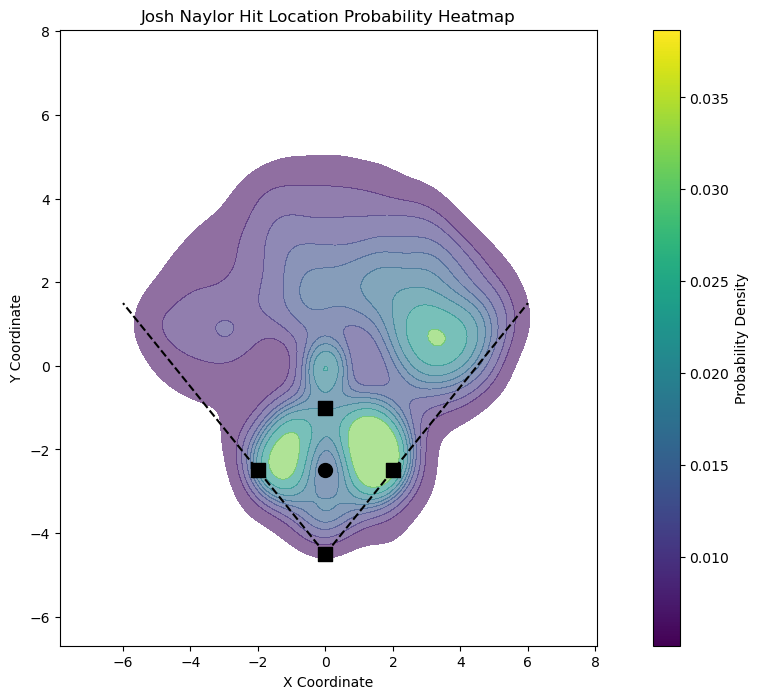

In [29]:

from scipy.stats import gaussian_kde
from matplotlib import gridspec

# Function to normalize probabilities excluding hit_location_0.0
def normalize_probabilities(probs, exclude='hit_location_0.0'):
    # Remove the probability for the excluded location
    probs_excluded = probs.drop(exclude, errors='ignore')
    total = probs_excluded.sum()
    # Normalize the remaining probabilities
    return probs_excluded / total

# Function to fit KDE models for each hit location and sample points
def sample_points_from_kde(df, df_probs, num_samples=1000):
    sampled_x, sampled_y = [], []

    # Normalize probabilities to exclude hit_location_0.0
    hit_location_probs = normalize_probabilities(df_probs)

    # Fit KDE for each hit location and sample points based on normalized probabilities
    for hit_loc, prob in hit_location_probs.items():
        # Filter the DataFrame to get rows where this hit_location is true
        hit_data = df[df[hit_loc] == 1]

        # Extract the coordinates and invert y-coordinates
        x_coords = hit_data['hc_x'].values
        y_coords = -hit_data['hc_y'].values

        # Skip if there are fewer than 3 points
        if len(x_coords) < 3:
            continue

        # Fit KDE model to the hit location data
        kde_model = gaussian_kde([x_coords, y_coords])

        # Determine how many points to sample based on normalized probability
        num_points = int(prob * num_samples)

        # Sample points from the fitted KDE model
        sampled_points = kde_model.resample(num_points)
        sampled_x.extend(sampled_points[0])
        sampled_y.extend(sampled_points[1])

    return sampled_x, sampled_y

# Function to plot combined KDE plot based on sampled points with a colorbar
def plot_combined_kde_with_colorbar(df, df_probs, num_samples=1000):
    # Get sampled points from KDE models of hit locations
    sampled_x, sampled_y = sample_points_from_kde(df, df_probs, num_samples)

    # Create a figure and GridSpec layout for the plot and colorbar
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1])  # 20:1 ratio between main plot and colorbar

    # Create axis for the KDE plot
    ax = plt.subplot(gs[0])

    # Plot KDE for all sampled points
    kde = sns.kdeplot(x=sampled_x, y=sampled_y, fill=True, cmap='viridis', alpha=0.6, ax=ax)

    # Retrieve the minimum and maximum density values for colorbar
    contour = kde.collections[-1]
    vmin = contour.get_array().min()
    vmax = contour.get_array().max()

    # Create a dedicated axis for the colorbar
    cax = plt.subplot(gs[1])

    # Create the colorbar in the dedicated axis
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cax, label='Probability Density')

    # Add foul lines
    ax.plot([0, 6], [-4.5, 1.5], color='black', linestyle='--', label="Foul Line", zorder=1)
    ax.plot([0, -6], [-4.5, 1.5], color='black', linestyle='--', zorder=1)

    # Add markers for bases and pitcher's mound
    base_marker_size = 100
    base_color = "black"
    ax.scatter(0, -4.5, color=base_color, label="Home Plate", s=base_marker_size, marker='s', zorder=2)
    ax.scatter(0, -2.5, color=base_color, label="Pitcher's Mound", s=base_marker_size, marker='o', zorder=2)
    ax.scatter(2, -2.5, color=base_color, label="First Base", s=base_marker_size, marker='s', zorder=2)
    ax.scatter(0, -1, color=base_color, label="Second Base", s=base_marker_size, marker='s', zorder=2)
    ax.scatter(-2, -2.5, color=base_color, label="Third Base", s=base_marker_size, marker='s', zorder=2)



    ax.set_title('Josh Naylor Hit Location Probability Heatmap')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    
    # Move the legend outside of the plot area to the right
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


    plt.show()

# Call the function with hit location means, probabilities, and full dataset
plot_combined_kde_with_colorbar(full_data[full_data['game_date'] > '2024-04-01'], player_preds.iloc[-1, 14:], num_samples=10000)


